In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.abspath('.')))

from utils.sql import *
from utils.vis import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
file_folder = os.path.join(os.path.abspath(''), '..', 'data')

vital_ref_dict = pd.read_csv(os.path.join(file_folder, 'vital_ref_dict'), header=0, index_col=[0])
df_info = pd.read_csv(os.path.join(file_folder, 'patient_information'), header=0, index_col=[0])
df_chart = pd.read_csv(os.path.join(file_folder, 'patient_chartdata'), header=0, index_col=[0])
df_chart['charttime'] = pd.to_datetime(df_chart['charttime'])

selected_items = np.load(os.path.join(file_folder, 'selected_items.npy'), allow_pickle=True).item()
item_vital = selected_items['vital']
item_resp = selected_items['resp']
item_lab = selected_items['lab']
item_treat = selected_items['treatment']
item_pain = selected_items['pain']

In [56]:
df_info['hadm_id'].unique().shape

(276,)

# Check Reference vital sign

In [3]:
def plot_vital_and_ref(gs, adm, vital_source, df_chart):
    ax = plt.subplot(gs)
    plt.xticks(rotation=30)
    data = df_chart[df_chart['hadm_id']==adm]
    colors_ref = ['dodgerblue', 'cornflowerblue', 'lightsteelblue']
    colors = ['maroon', 'firebrick', 'lightcoral']
    if vital_source == 'HR':
        iids = [220045] # HR
        iids_ref = [223764, 223765, 224647] # HR lying, HR sitting, HR standing
        ref_labels = ['HR lying', 'HR sitting', 'HR standing']
        for i, iid in enumerate(iids):
            ct = pd.to_datetime(data[data['itemid']==iid]['charttime'])
            val = data[data['itemid']==iid]['valuenum']
            ax.plot(
                ct, 
                val,
                c=colors[i],
                label='HR',
            )
        for i, iid in enumerate(iids_ref):
            ct_last = pd.to_datetime(data['charttime'].max())
            val_last = data[data['itemid']==iid].sort_values('charttime')['valuenum'].iloc[-1]
            ct = pd.to_datetime(data[data['itemid']==iid]['charttime']).to_list() + [ct_last]
            val = data[data['itemid']==iid]['valuenum'].to_list() + [val_last]
            ax.plot(
                ct, 
                val,
                drawstyle='steps-post',
                c=colors_ref[i],
                linestyle='dashed',
                label=ref_labels[i],
            )
    elif vital_source == 'NBP':
        iids = [220179, 220180, 220181] # NBPs, NBPd, NBPm
        iids_ref = [224645, 224646, 223766, # BPs lying, BPs sitting, BPs standing
                    226092, 226094, 226096] # BPd lying, BPd sitting, BPd standing
        data_labels = ['BPs', 'BPd', 'BPm']
        ref_labels = ['BPs lying', 'BPs sitting', 'BPs standing',
                      'BPd lying', 'BPd sitting', 'BPd standing',]
        for i, iid in enumerate(iids):
            ct = pd.to_datetime(data[data['itemid']==iid]['charttime'])
            val = data[data['itemid']==iid]['valuenum']
            ax.plot(
                ct, 
                val,
                c=colors[i],
                label=data_labels[i],
            )
        for i, iid in enumerate(iids_ref):
            ct_last = pd.to_datetime(data['charttime'].max())
            val_last = data[data['itemid']==iid].sort_values('charttime')['valuenum'].iloc[-1]
            ct = pd.to_datetime(data[data['itemid']==iid]['charttime']).to_list() + [ct_last]
            val = data[data['itemid']==iid]['valuenum'].to_list() + [val_last]
            ax.plot(
                ct, 
                val,
                drawstyle='steps-post',
                c=colors_ref[i%3],
                linestyle='dashed',
                label=ref_labels[i],
            )
        
    else:
        raise AssertionError('Only support vital references for "HR" and "NBP".')

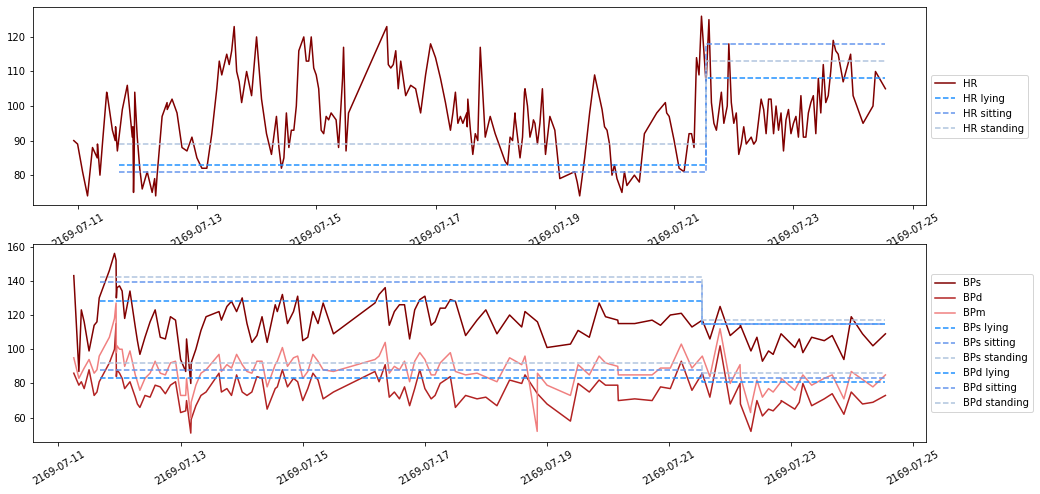

In [4]:
admissions = df_info['hadm_id'].to_list()
adm = admissions[10]


fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 1) 

plot_vital_and_ref(gs[0], adm, 'HR', df_chart)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_vital_and_ref(gs[1], adm, 'NBP', df_chart)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

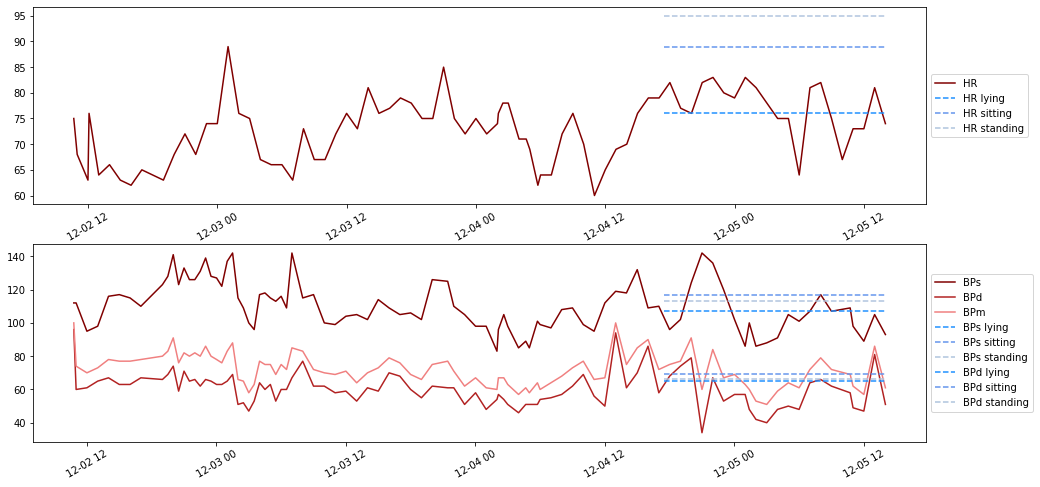

In [5]:
admissions = df_info['hadm_id'].to_list()
adm = admissions[41]


fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(2, 1) 

plot_vital_and_ref(gs[0], adm, 'HR', df_chart)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_vital_and_ref(gs[1], adm, 'NBP', df_chart)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Day-Night Seasonality

In [6]:
from scipy.interpolate import interp1d
import numpy as np

In [7]:
# interpolate data to be evenly spaced

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

data = df_chart[(df_chart['hadm_id']==adm)]
x_dt = pd.to_datetime(data[df_chart['itemid']==220045]['charttime']).values
x = get_unixtime(x_dt)
y = data[df_chart['itemid']==220045]['valuenum'].values

f_linear = interp1d(x, y, kind='linear')
f_cubic = interp1d(x, y, kind='cubic')
f_nearest = interp1d(x, y, kind='nearest')
f_prev = interp1d(x, y, kind='previous')

x_dt_ = np.array(pd.date_range(x_dt[0], x_dt[-1], freq='1H').to_pydatetime(), dtype=np.datetime64)
x_ = get_unixtime(x_dt_)
y_linear = f_linear(x_)
y_cubic = f_cubic(x_)
y_nearest = f_nearest(x_)
y_prev = f_prev(x_)

/tmp/ipykernel_540150/1934207137.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x_dt = pd.to_datetime(data[df_chart['itemid']==220045]['charttime']).values
/tmp/ipykernel_540150/1934207137.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = data[df_chart['itemid']==220045]['valuenum'].values


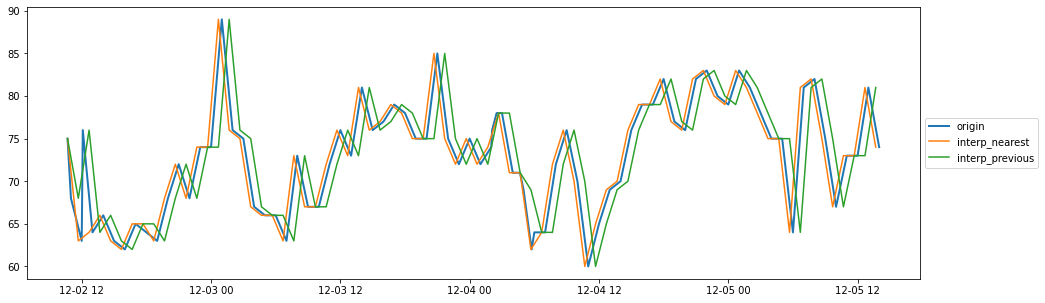

In [8]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 1) 

ax = plt.subplot(gs[0])
ax.plot(x_dt, y, label='origin', linewidth=2)
# ax.plot(x_dt_, y_linear, label='interp_linear')
# ax.plot(x_dt_, y_cubic, label='interp_cubic')
ax.plot(x_dt_, y_nearest, label='interp_nearest')
ax.plot(x_dt_, y_prev, label='interp_previous')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

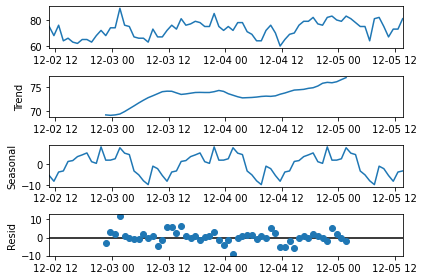

In [10]:
# Naive seasonal decomposition

df_hr = pd.DataFrame(y_prev, index=x_dt_, columns=['HR'])
result = seasonal_decompose(df_hr, period=24, model='additive')
fig = result.plot()

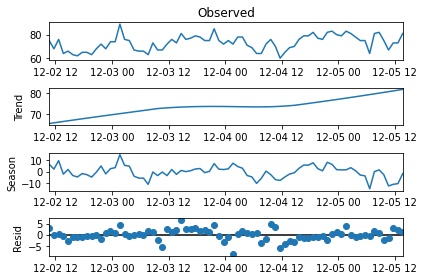

In [11]:
result = STL(df_hr, period=24).fit()
fig = result.plot()

# smoothing trend & seaconal curve

In [12]:
from loess.loess_1d import loess_1d

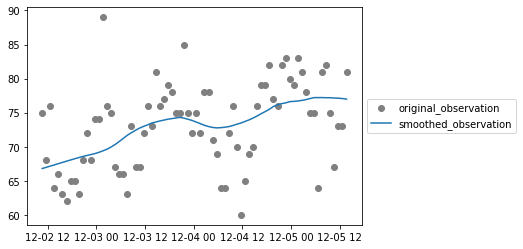

In [13]:
x = np.array([xi for xi in range(len(result.observed))])
xout, yout, wout = loess_1d(x, result.observed.values.flatten(), xnew=None, degree=1, frac=0.5,
                            npoints=None, rotate=False, sigy=None)
plt.scatter(result.observed.index, result.observed.values, c='gray', label='original_observation')
plt.plot(result.observed.index, yout, label='smoothed_observation')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

-0.016566929931538965 2.5144325351824213
-0.07661084088496 2.393190251609122


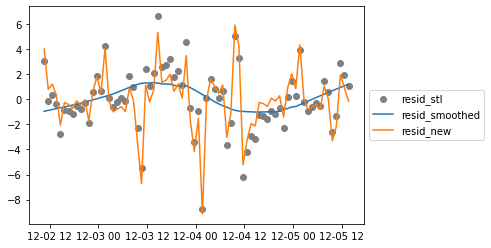

In [14]:
x = np.array([xi for xi in range(len(result.resid))])
resid_loess_x, resid_loess_y, resid_loess_w = loess_1d(x, result.resid.values, xnew=None, degree=1, frac=0.5,
                                                       npoints=None, rotate=False, sigy=None)

resid_new = result.resid-resid_loess_y
print(result.resid.mean(), result.resid.std())
print(resid_new.mean(), resid_new.std())

plt.scatter(result.resid.index, result.resid.values, label='resid_stl', c='gray')
plt.plot(result.resid.index, resid_loess_y, label='resid_smoothed')
plt.plot(resid_new, label='resid_new')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

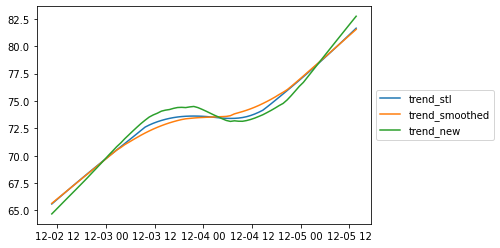

In [15]:
x = np.array([xi for xi in range(len(result.trend))])
trend_loess_x, trend_loess_y, trend_loess_w = loess_1d(x, result.trend.values, xnew=None, degree=1, frac=0.5,
                                                       npoints=None, rotate=False, sigy=None)

trend_new = trend_loess_y + resid_loess_y

plt.plot(result.trend, label='trend_stl')
plt.plot(result.trend.index, trend_loess_y, label='trend_smoothed')
plt.plot(result.trend.index, trend_new, label='trend_new')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

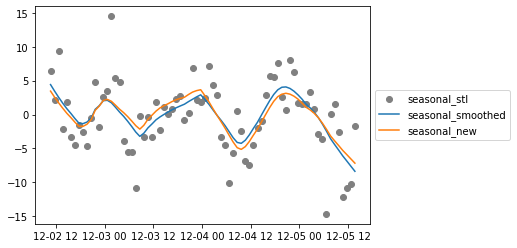

In [16]:
x = np.array([xi for xi in range(len(result.seasonal))])
seasonal_loess_x, seasonal_loess_y, seasonal_loess_w = loess_1d(x, result.seasonal.values, 
                                                                xnew=None, degree=1, frac=0.2,
                                                                npoints=None, rotate=False, sigy=None)
seasonal_new = seasonal_loess_y + resid_loess_y

plt.scatter(result.seasonal.index, result.seasonal.values, label='seasonal_stl', c='gray')
plt.plot(result.seasonal.index, seasonal_loess_y, label='seasonal_smoothed')
plt.plot(result.seasonal.index, seasonal_new, label='seasonal_new')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

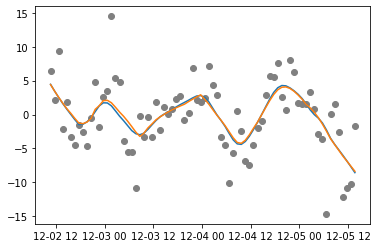

In [17]:
import statsmodels.api as sm
seasonal_ = sm.nonparametric.lowess(result.seasonal.values, x, frac=0.2)

plt.scatter(result.seasonal.index, result.seasonal.values, label='seasonal_stl', c='gray')
plt.plot(result.seasonal.index, seasonal_[:,1])
plt.plot(result.seasonal.index, seasonal_loess_y, label='seasonal_smoothed')

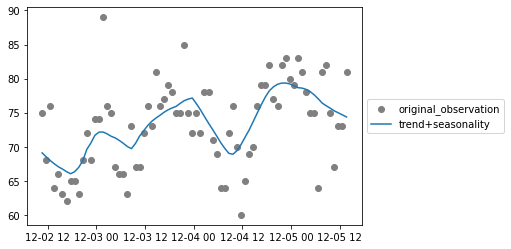

In [18]:
smoothed_observed = trend_loess_y + seasonal_new

plt.scatter(result.observed.index, result.observed.values, c='gray', label='original_observation')
plt.plot(result.observed.index, smoothed_observed, label='trend+seasonality')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [19]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def sin_fit(x, *p):
    y = []
    for xi in x:
        a = p[0]*xi + p[1]
        b = p[2]
        c = p[3]
        d = p[4]*xi + p[5]
        y.append(a * np.sin( b * xi + c ) + d)
    
    return y
    
def gaussian_fit(x, *p):
    y = np.zeros_like(x)
    for i in range(0, len(p), 3):
        a = p[i]
        m = p[i+1]
        sigma = p[i+2]
        y = y + a * np.exp( -((x - m)/sigma)**2)
    return y

(27.34274477410923, 26.560009497446178, 4.101198096313941, 4.013702602819166)

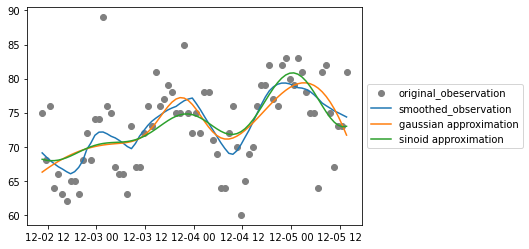

In [20]:
# init param for gaussian function
i_pk, _ = find_peaks(smoothed_observed, distance=12)

guess_gauss = []
for pk in i_pk:
    guess_gauss.append([smoothed_observed[pk], pk, 24]) 
    
# init param for sinus function
T = 2*np.pi/24
drift_rate = (result.trend[-1] - result.trend[0]) / (len(result.trend)-1)
drift_mean = smoothed_observed.mean()
guess_sin = [1, 1, T, 1, drift_rate, drift_mean]

# x-axis as numeric array
x = [xi for xi in range(len(smoothed_observed))]

# fit gaussian
popt_gauss, pcov_gauss = curve_fit(gaussian_fit, x, smoothed_observed, guess_gauss)
y_gauss = gaussian_fit(x, *popt_gauss)

# fit sinus
popt_sin, pcov_sin = curve_fit(sin_fit, x, smoothed_observed, guess_sin)
y_sin = sin_fit(x, *popt_sin)

plt.scatter(result.observed.index, result.observed.values, c='gray', label='original_obeservation')
plt.plot(result.observed.index, smoothed_observed, label='smoothed_observation')
plt.plot(result.observed.index, y_gauss, label='gaussian approximation')
plt.plot(result.observed.index, y_sin, label='sinoid approximation')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

((y_gauss - result.observed.values.flatten())**2).mean(), \
((y_sin - result.observed.values.flatten())**2).mean(), \
(np.abs(y_gauss - result.observed.values.flatten())).mean(), \
(np.abs(y_sin - result.observed.values.flatten())).mean()

(26.460763049267115, 25.315259499377966, 3.980239479060544, 3.9409918172112826)

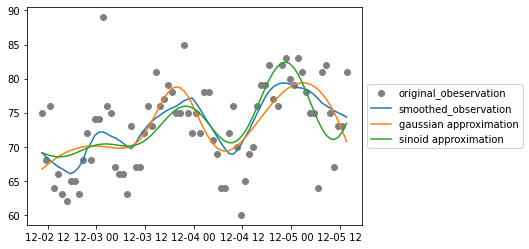

In [21]:
# fit gaussian
popt_gauss, pcov_gauss = curve_fit(gaussian_fit, x, result.observed.values.flatten(), guess_gauss)
y_gauss = gaussian_fit(x, *popt_gauss)

# fit sinus
popt_sin, pcov_sin = curve_fit(sin_fit, x, result.observed.values.flatten(), guess_sin)
y_sin = sin_fit(x, *popt_sin)

plt.scatter(result.observed.index, result.observed.values, c='gray', label='original_obeservation')
plt.plot(result.observed.index, smoothed_observed, label='smoothed_observation')
plt.plot(result.observed.index, y_gauss, label='gaussian approximation')
plt.plot(result.observed.index, y_sin, label='sinoid approximation')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

((y_gauss - result.observed.values.flatten())**2).mean(), \
((y_sin - result.observed.values.flatten())**2).mean(), \
(np.abs(y_gauss - result.observed.values.flatten())).mean(), \
(np.abs(y_sin - result.observed.values.flatten())).mean()

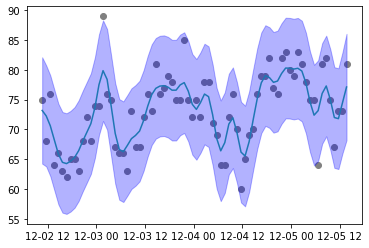

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared, RationalQuadratic
from scipy.stats import norm

def plot_gp(ax, x_plot, y_plot, color='r'):
#     std = np.sqrt(np.diag(cov))
    
    ax.plot(x_plot, y_plot, color=color, linewidth=3)
#     ax.fill_between(np.linspace(0, 5, len(mean)), mean.flatten() - 2 * std, mean.flatten() + 2 * std, alpha=0.3, color=color)
    return ax

# Nday = (result.observed.index[-1] - result.observed.index[0]).ceil('D').days
# gmm = GaussianMixture(n_components = Nday, max_iter=1000, random_state=0, covariance_type = 'full')

x_gmm = []
y_gmm = []
for i, xi in enumerate(result.observed.values.flatten()):
    x_gmm.append([i])
    y_gmm.append([xi])

kernel = 1 * RBF(length_scale=25, length_scale_bounds=(1,50)) \
         + WhiteKernel(noise_level=0.2, noise_level_bounds=(1e-10, 1e+1))

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha=1e-2,
                               random_state=0,
                               normalize_y=True,
                               n_restarts_optimizer=5)

gpr.fit(x_gmm, y_gmm)

gpr_pred, gpr_cov = gpr.predict(x_gmm, return_cov=True)
std = np.sqrt(np.diag(gpr_cov))

# # create necessary things to plot
# x_axis = result.observed.index
# y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
# y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

# plt.plot(x_axis, y_axis0, lw=3, c='C0')
# plt.plot(x_axis, y_axis1, lw=3, c='C1')
# plt.plot(x_axis, y_axis0+y_axis1, lw=3, c='C2', ls='dashed')

plt.scatter(result.observed.index, result.observed.values, c='gray', label='original_obeservation')
plt.plot(result.observed.index, gpr_pred)
plt.fill_between(result.observed.index, gpr_pred.flatten() - 2 * std, gpr_pred.flatten() + 2 * std, alpha=0.3, color='b')

In [23]:
from sklearn.mixture import GaussianMixture

Nday = (result.observed.index[-1] - result.observed.index[0]).ceil('D').days
gmm = GaussianMixture(n_components = Nday, max_iter=1000, random_state=0, covariance_type = 'full')

gmm.fit(x_gmm, y_gmm)

GaussianMixture(max_iter=1000, n_components=4, random_state=0)

[[43.64677157]
 [24.37953901]
 [64.26012617]
 [ 7.70010138]]


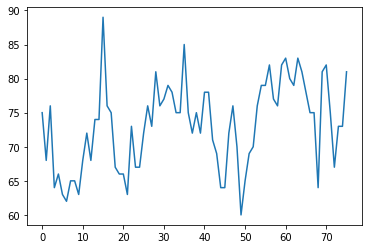

In [24]:
print(gmm.means_)
plt.plot(y_gmm)

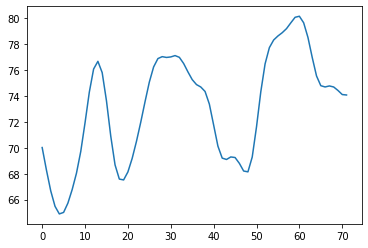

In [25]:
gpr_smooth = np.convolve(gpr_pred.flatten(), np.ones(5)/5, "valid")
plt.plot(gpr_smooth)

# trend and seasonality with Gaussian process

# plot seasonality multiple patient

In [40]:
import statsmodels.api as sm

def align_datetime(data):
    ref_ct = np.datetime64('2020-01-01')
    ct = pd.to_datetime(data['charttime']).copy().values
    ct = ct - ct[0].astype('datetime64[D]') + ref_ct
    
    return ct


def interpolate_charttime_data(data, iid=220045):
    x_dt = data[data['itemid']==iid]['charttime'].values
    x = get_unixtime(x_dt)
    y = data[data['itemid']==iid]['valuenum'].values
    
    f_interp = interp1d(x, y, kind='previous')
    
    x_dt_ = np.array(pd.date_range(x_dt[0], x_dt[-1], freq='1H').to_pydatetime(), dtype=np.datetime64)
    x_ = get_unixtime(x_dt_)
    y_ = f_interp(x_)
    
    return x_dt_, y_


def calculate_smoothed_seasonal(stl, frac=None):
    x = np.array([xi for xi in range(len(stl.observed))])
    
    if frac is None:
        frac = 20 / len(x)
        if frac > 0.5:
            frac = 0.5
    #     print(frac)
    seasonal_smoothed = sm.nonparametric.lowess(stl.seasonal.values, x, frac=frac)
    
    return seasonal_smoothed[:,1]

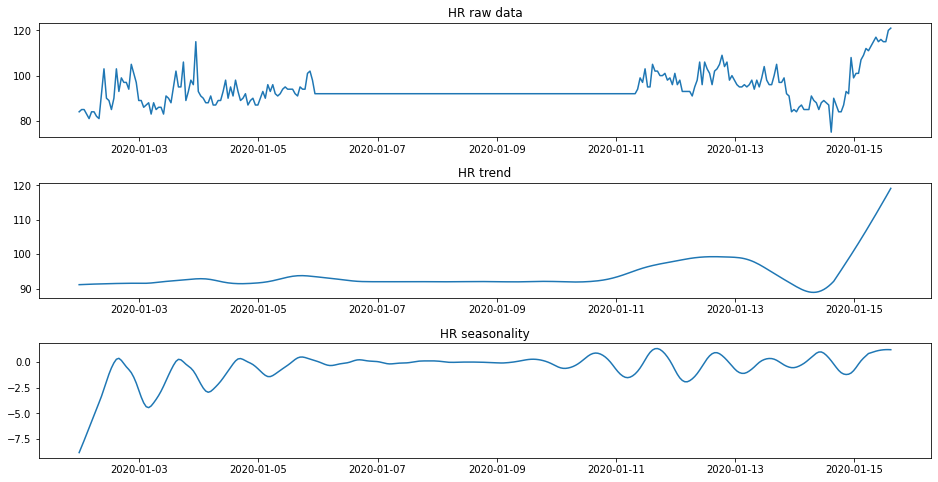

In [27]:
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=.4)
gs = gridspec.GridSpec(3, 1) 

ax_raw = plt.subplot(gs[0])
ax_trend = plt.subplot(gs[1])
ax_seasonal = plt.subplot(gs[2])

iid = item_dict[item_dict['label']=='Heart Rate']['itemid'].item()
i = 200
for adm in admissions[i:i+1]:
    data = df_chart[(df_chart['hadm_id']==adm) & (df_chart['itemid']==iid)].copy()
    data['charttime'] = align_datetime(data)
    
    ct_interp, data_interp = interpolate_charttime_data(data)
    
    df_data = pd.DataFrame(data_interp, index=ct_interp)
    stl = STL(df_data, period=24).fit()
    trend = stl.trend.values
    seasonal = calculate_smoothed_seasonal(stl)
    
    ax_raw.set_title('HR raw data')
    ax_raw.plot(ct_interp, data_interp)
    ax_trend.set_title('HR trend')
    ax_trend.plot(ct_interp, trend)
    ax_seasonal.set_title('HR seasonality')
    ax_seasonal.plot(ct_interp, seasonal)

# plot mobility and pain
events

In [26]:
def get_data_near_event(data, event_time, toi_h):
    # toi_h: time range of interest in hour
    delta_t = np.timedelta64(toi_h, 'h')
    begin = event_time - delta_t
    end = event_time + delta_t
    data_ = data[(data['charttime']>=begin) & (data['charttime']<=end)]
    return data_

In [29]:
# 229321: Activity / Mobility (JH-HLM)

walk_events = df_chart[df_chart['value'].str.fullmatch('^.*Walk.*')]
walk_adms = walk_events['hadm_id'].unique()
walk_cts = walk_events['charttime'].values

# walk_data = get_data_near_event()

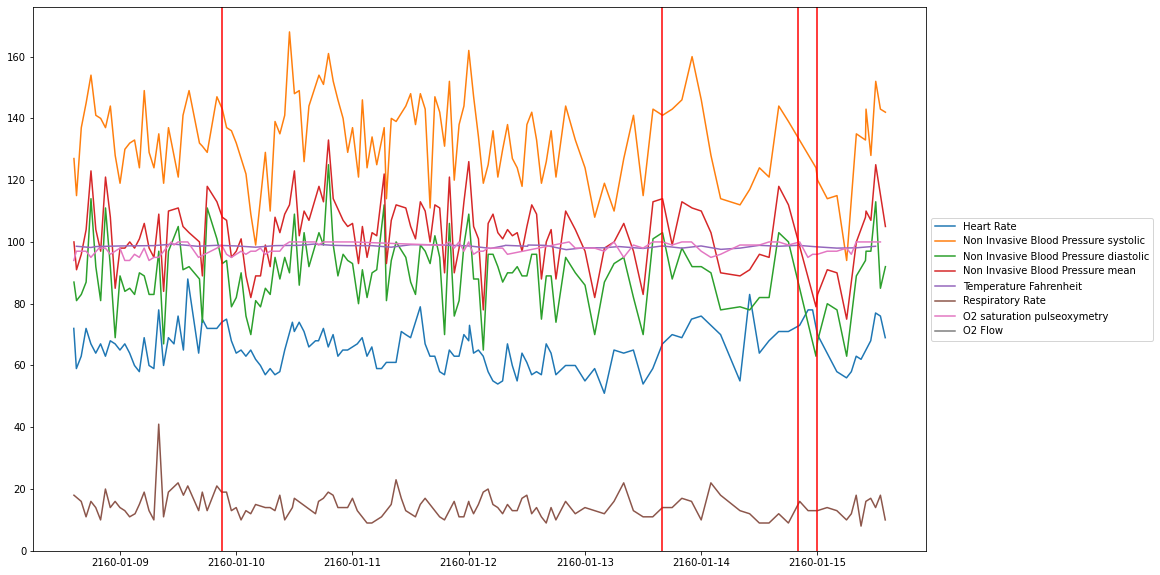

In [30]:
adm = walk_adms[100]
# adm = admissions[41]
adm_data = df_chart[df_chart['hadm_id']==adm]

fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(1, 1) 
ax = plt.subplot(gs[0])

plot_data(gs[0], adm_data, item_vital)
plot_data(gs[0], adm_data, item_resp)

walk_event = walk_events[walk_events['hadm_id']==adm]
for ct in pd.to_datetime(walk_event['charttime']).values:
    ax.axvline(ct, color='r')

In [31]:
df_data

,0
2020-01-01 23:47:00,84.0
2020-01-02 00:47:00,85.0
2020-01-02 01:47:00,85.0
2020-01-02 02:47:00,83.0
2020-01-02 03:47:00,81.0
...,...
2020-01-15 10:47:00,116.0
2020-01-15 11:47:00,115.0
2020-01-15 12:47:00,115.0
2020-01-15 13:47:00,120.0


Text(0.5, 1.0, 'Noise')

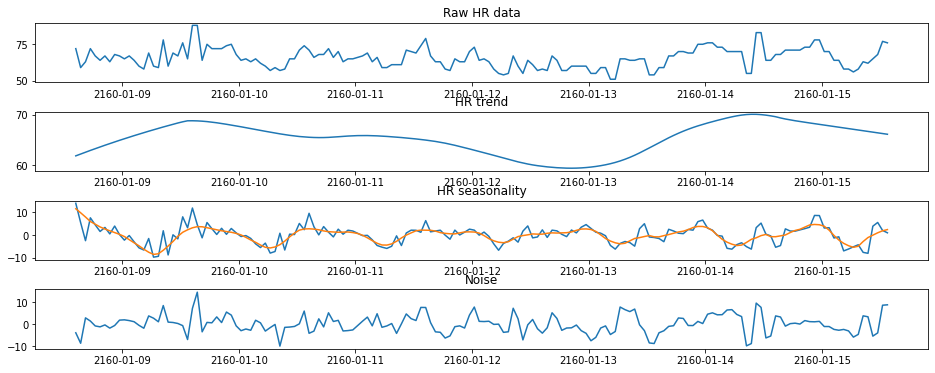

In [44]:
ct_interp, data_interp = interpolate_charttime_data(adm_data)
    
df_data = pd.DataFrame(data_interp, index=ct_interp)
stl = STL(df_data, period=24).fit()
trend = stl.trend.values
seasonal = calculate_smoothed_seasonal(stl, 0.05)

fig = plt.figure(figsize=(16,6))
plt.subplots_adjust(hspace=0.5)
gs = gridspec.GridSpec(4, 1) 

ax_raw = plt.subplot(gs[0])
ax_trend = plt.subplot(gs[1])
ax_seasonal = plt.subplot(gs[2])
ax_noise = plt.subplot(gs[3])

ax_raw.plot(df_data)
ax_raw.set_title('Raw HR data')
ax_trend.plot(ct_interp, trend)
ax_trend.set_title('HR trend')
ax_seasonal.plot(ct_interp, stl.seasonal.values)
ax_seasonal.plot(ct_interp, seasonal)
ax_seasonal.set_title('HR seasonality')
ax_noise.plot(ct_interp, stl.resid.values)
ax_noise.set_title('Noise')

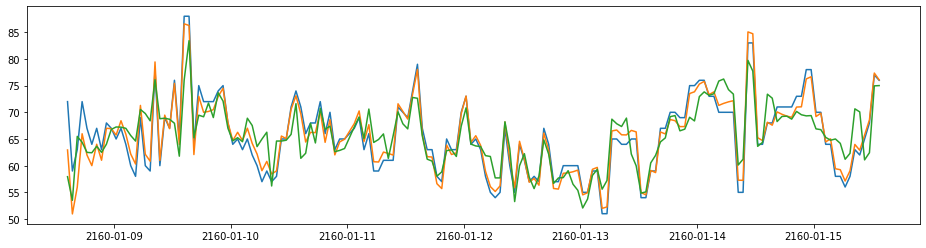

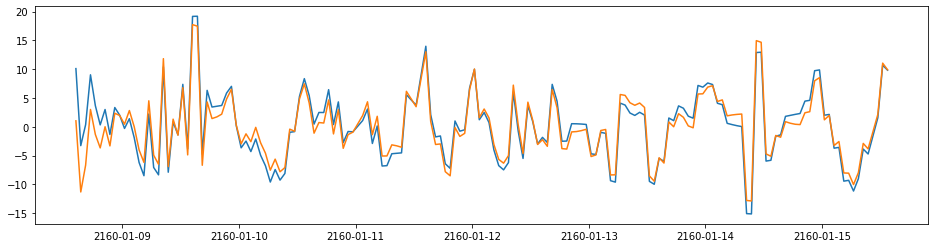

In [155]:
fig = plt.figure(figsize=(16,4))
plt.plot(df_data)
plt.plot(df_data-pd.DataFrame(seasonal, index=ct_interp))
plt.plot(df_data-pd.DataFrame(stl.seasonal.values, index=ct_interp))

fig = plt.figure(figsize=(16,4))
plt.plot(df_data-pd.DataFrame(trend, index=ct_interp))
# plt.plot(df_data-pd.DataFrame(stl.resid.values, index=ct_interp))
plt.plot(df_data-pd.DataFrame(seasonal+trend, index=ct_interp))
# plt.plot(df_data-pd.DataFrame(seasonal+trend+stl.resid.values, index=ct_interp))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


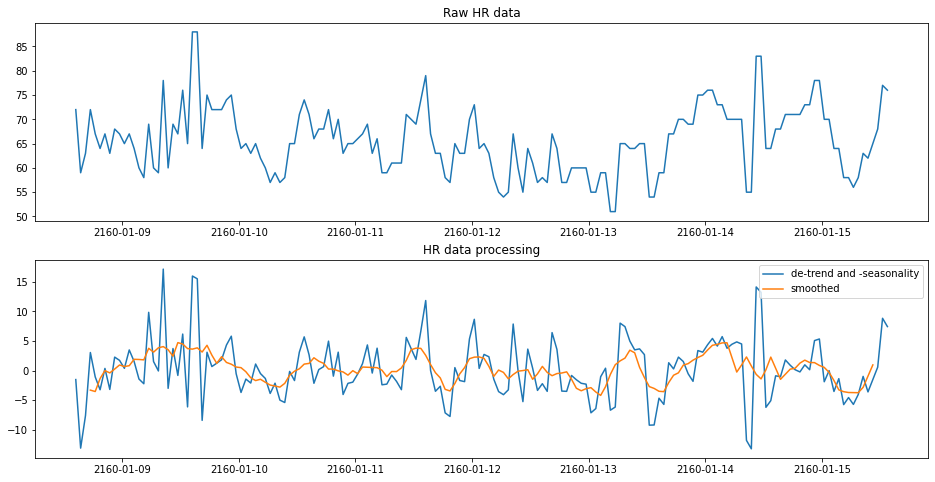

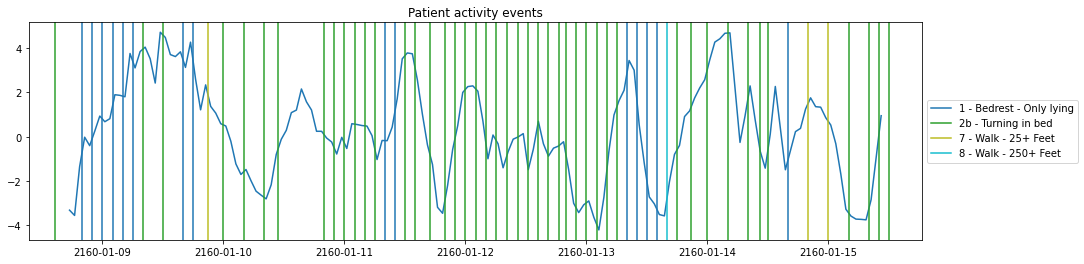

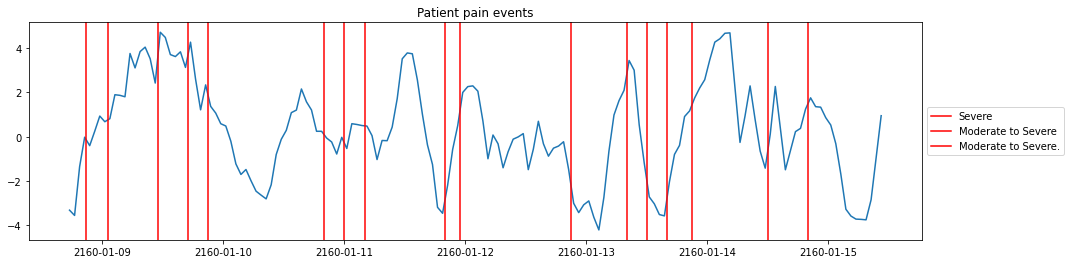

In [54]:
window_size = 7
data_ = df_data-pd.DataFrame(seasonal+trend, index=ct_interp)
data_smoothed = data_.rolling(window_size, center=True).sum() / window_size

fig, ax = plt.subplots(2, 1, figsize=(16,8))
ax[0].plot(df_data, label='raw')
ax[0].set_title('Raw HR data')
plt.legend(loc='upper right')

ax[1].set_title('HR data processing')
ax[1].plot(data_, label='de-trend and -seasonality')
ax[1].plot(data_smoothed, label='smoothed')
plt.legend(loc='upper right')



fig = plt.figure(figsize=(16,4))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

ax.plot(data_smoothed)
ax.set_title('Patient activity events')
# mobility activity
mobility_list = np.sort(df_chart[df_chart['itemid']==229321]['value'].unique())
for i, act in enumerate(mobility_list):
    df_act = adm_data[adm_data['value']==act]
    for _, d in df_act.iterrows():
        ct = d['charttime']
        ax.axvline(ct, label=d['value'], c=plt.cm.tab10(i))
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
           loc='center left', bbox_to_anchor=(1, 0.5))

        
# pain_event   
fig = plt.figure(figsize=(16,4))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0])

ax.plot(data_smoothed)
ax.set_title('Patient pain events')
pain_severe = ['Moderate to Severe', 'Moderate to Severe.', 
               'Severe', 'Severe to Worse', 'Worst']
df_pain = adm_data[(adm_data['itemid']==223791) & (adm_data['value'].isin(pain_severe))]

for _, d in df_pain.iterrows():
        ct = d['charttime']
        ax.axvline(ct, label=d['value'], c='r')
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), 
           loc='center left', bbox_to_anchor=(1, 0.5))


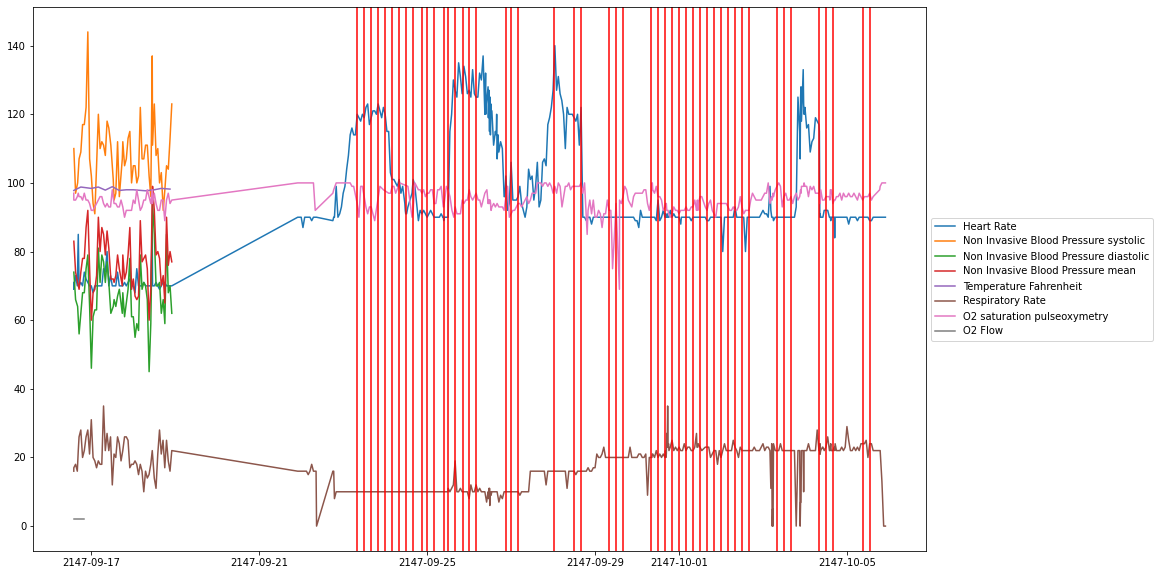

In [113]:
adm = df_pain_by_vitals['hadm_id'].unique()[11]
adm_data = df_chart[df_chart['hadm_id']==adm]
adm_data['charttime'] = pd.to_datetime(adm_data['charttime'])

fig = plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(1, 1) 
ax = plt.subplot(gs[0])

plot_data(gs[0], adm_data, item_vital)
plot_data(gs[0], adm_data, item_resp)

pain_by_vitals_event = df_pain_by_vitals[df_pain_by_vitals['hadm_id']==adm]
for ct in pd.to_datetime(pain_by_vitals_event['charttime']).values:
    ax.axvline(ct, color='r')

In [100]:
pd.to_datetime(pain_by_vitals_event['charttime']).values

array(['2128-04-28T16:14:00.000000000', '2128-04-28T18:03:00.000000000'],
      dtype='datetime64[ns]')

In [96]:
adm_data[adm_data['itemid']==223795]

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
1154,12375699,20031565,34050341,2128-04-16 18:50:00,2128-04-16 18:50:00,223795,Patient Verbalized,NaN,NaN,0
1174,12375699,20031565,34050341,2128-04-16 20:00:00,2128-04-17 00:07:00,223795,Patient Verbalized,NaN,NaN,0
1233,12375699,20031565,34050341,2128-04-17 00:00:00,2128-04-17 00:25:00,223795,Patient Verbalized,NaN,NaN,0
1333,12375699,20031565,34568439,2128-04-28 16:14:00,2128-04-28 16:14:00,223795,Change in Vitals,NaN,NaN,0
1353,12375699,20031565,34568439,2128-04-28 18:03:00,2128-04-28 18:03:00,223795,Change in Vitals,NaN,NaN,0
1383,12375699,20031565,34568439,2128-04-28 20:10:00,2128-04-28 20:11:00,223795,Non-verbal Cues,NaN,NaN,0
1436,12375699,20031565,34568439,2128-04-29 00:00:00,2128-04-29 01:00:00,223795,Patient Verbalized,NaN,NaN,0
1500,12375699,20031565,34568439,2128-04-29 04:00:00,2128-04-29 05:01:00,223795,Patient Verbalized,NaN,NaN,0
1555,12375699,20031565,34568439,2128-04-29 08:00:00,2128-04-29 09:54:00,223795,Patient Verbalized,NaN,NaN,0
1579,12375699,20031565,34568439,2128-04-29 09:59:00,2128-04-29 10:00:00,223795,Patient Verbalized,NaN,NaN,0


In [91]:
adm_data

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
1333,12375699,20031565,34568439,2128-04-28 16:14:00,2128-04-28 16:14:00,223795,Change in Vitals,NaN,NaN,0
1353,12375699,20031565,34568439,2128-04-28 18:03:00,2128-04-28 18:03:00,223795,Change in Vitals,NaN,NaN,0


In [12]:
item_dict[item_dict['abbreviation'].str.fullmatch('^NBP.')]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
22,220179,Non Invasive Blood Pressure systolic,NBPs,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
23,220180,Non Invasive Blood Pressure diastolic,NBPd,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
24,220181,Non Invasive Blood Pressure mean,NBPm,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


In [13]:
vital_ref_dict

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,223764,Orthostatic HR lying,Orthostatic HR lying,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
1,223765,Orthostatic HR sitting,Orthostatic HR sitting,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
2,223766,Orthostatic BPs standing,Orthostatic BPs standing,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
3,224645,Orthostatic BPs lying,Orthostatic BPs lying,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
4,224646,Orthostatic BPs sitting,Orthostatic BPs sitting,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
5,224647,Orthostatic HR standing,Orthostatic HR standing,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
6,226092,Orthostatic BPd lying,Orthostatic BPd lying,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
7,226094,Orthostatic BPd sitting,Orthostatic BPd sitting,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
8,226096,Orthostatic BPd standing,Orthostatic BPd standing,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN


In [15]:
vital_ref_dict[vital_ref_dict['abbreviation'].str.fullmatch('^.*HR.*')]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
0,223764,Orthostatic HR lying,Orthostatic HR lying,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
1,223765,Orthostatic HR sitting,Orthostatic HR sitting,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN
5,224647,Orthostatic HR standing,Orthostatic HR standing,chartevents,Routine Vital Signs,bpm,Numeric,NaN,NaN


In [16]:
vital_ref_dict[vital_ref_dict['abbreviation'].str.fullmatch('^.*BP.*')]

,itemid,label,abbreviation,linksto,category,unitname,param_type,lownormalvalue,highnormalvalue
2,223766,Orthostatic BPs standing,Orthostatic BPs standing,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
3,224645,Orthostatic BPs lying,Orthostatic BPs lying,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
4,224646,Orthostatic BPs sitting,Orthostatic BPs sitting,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
6,226092,Orthostatic BPd lying,Orthostatic BPd lying,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
7,226094,Orthostatic BPd sitting,Orthostatic BPd sitting,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
8,226096,Orthostatic BPd standing,Orthostatic BPd standing,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,NaN
